# Import and Setup

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import sys
!pwd
sys.path.append('/g/g99/jamil1/lustre1/sensitivity/modules')

/p/lustre1/jamil1/sensitivity/work/SensitivityPaper2020_scripts/DiscoveryPotential


Import useful libraries for analysis

In [3]:
import pandas as pd
import histlite as hl
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
params = {'font.size':16,'font.family':'serif'}
plt.rcParams.update(params) 
import os

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10,8)

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

Import the nEXO sensitivity classes

In [4]:
import nEXOFitWorkspace
import nEXOFitModel
import nEXOFitLikelihood

Useful functions

In [5]:
from decimal import Decimal

def ProgressBar(count, total, phrase):
    barLength = 15 # Modify this to change the length of the progress bar
    status = '%d/%d' % (count+1, total)
    progress = (count+1)/float(total)
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if count == total-1:
        progress = 1
        status = status+"           \n"
    block = int(round(barLength*progress))
    text = '\r%-*s [%s] %-*s %s' % (47,phrase,"#"*block+"-"*(barLength-block),8,'%.2f%%'%Decimal(progress*100),status)
    sys.stdout.write(text)
    sys.stdout.flush()

In [6]:
import re

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [7]:
mmass_xe136 = 135.907214 # in g/mol 
mmass_xe134 = 133.905393 # in g/mol 
Avogadro = 6.022E23 # in 1/mol
bb0n_eff = 0.963
XeMass_fiducial = 3281.0 # in kg
frac_136 = 0.9
frac_134 = 0.1

def GetLivetime(Num, Livetime):
    print(Num,Livetime)
    return bb0n_eff * XeMass_fiducial*1000.0 * (frac_136/mmass_xe136 + frac_134/mmass_xe134) * Avogadro * Livetime * np.log(2.0) / Num

# Data Read-In

In [8]:
OutputDir = '/g/g99/jamil1/lustre1/sensitivity/work/SensitivityPaper2020_scripts/DiscoveryPotential/Data/version1/h5/'

AllFiles = os.listdir(OutputDir)
H5Files = [filename for filename in AllFiles if filename.endswith('.h5')]
print('Number of files {}'.format(len(H5Files)))


Number of files 4000


In [9]:
Livetimes = [1.0,5.0,10.0]
Livetimes = [10.0]

Tags = {}
for Livetime in Livetimes: 
    Tags[Livetime] = natural_sort(np.unique(['_'.join(x.split('_')[:3])+'_%.1fyrs' % Livetime for x in H5Files if '%.1fyrs' % Livetime in x]))
    print(Tags[Livetime])

['DiscoveryPotential_bb0n_0ct_10.0yrs', 'DiscoveryPotential_bb0n_7ct_10.0yrs', 'DiscoveryPotential_bb0n_12ct_10.0yrs', 'DiscoveryPotential_bb0n_18ct_10.0yrs', 'DiscoveryPotential_bb0n_20ct_10.0yrs', 'DiscoveryPotential_bb0n_22ct_10.0yrs', 'DiscoveryPotential_bb0n_25ct_10.0yrs']


In [10]:
dfdict = {}

for Livetime in Livetimes: 
    dfdict[Livetime] = {}
    for category in Tags[Livetime]:
        print('Loading data for {}'.format(category))
        df_list = [pd.read_hdf(OutputDir+filename) for filename in H5Files if category in filename]
        dfdict[Livetime][category] = pd.concat(df_list,ignore_index=True)
        print('Number of file for {}: {}'.format(category, len(df_list)))

Loading data for DiscoveryPotential_bb0n_0ct_10.0yrs
Number of file for DiscoveryPotential_bb0n_0ct_10.0yrs: 1000
Loading data for DiscoveryPotential_bb0n_7ct_10.0yrs
Number of file for DiscoveryPotential_bb0n_7ct_10.0yrs: 500
Loading data for DiscoveryPotential_bb0n_12ct_10.0yrs
Number of file for DiscoveryPotential_bb0n_12ct_10.0yrs: 500
Loading data for DiscoveryPotential_bb0n_18ct_10.0yrs
Number of file for DiscoveryPotential_bb0n_18ct_10.0yrs: 500
Loading data for DiscoveryPotential_bb0n_20ct_10.0yrs
Number of file for DiscoveryPotential_bb0n_20ct_10.0yrs: 500
Loading data for DiscoveryPotential_bb0n_22ct_10.0yrs
Number of file for DiscoveryPotential_bb0n_22ct_10.0yrs: 500
Loading data for DiscoveryPotential_bb0n_25ct_10.0yrs
Number of file for DiscoveryPotential_bb0n_25ct_10.0yrs: 500


# Selection Cut
Prevent datasets from entering the distribution of test statistics for which either one of the hypothesis test fits with a fixed number of bb0n counts or the global best fit did not converge

In [11]:
maskdict = {}


for Livetime in Livetimes: 
    maskdict[Livetime] = {} 
    for key, df in dfdict[Livetime].items():
        print('Running {}'.format(key))
        good_fit_mask = []
        counts = 0
        for index,row in df.iterrows():
            if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar'])-1 or not row['best_fit_covar'] or not row['best_fit_converged'] or np.min(row['lambda']) < -0.1:
#             if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar'])-1 or not row['best_fit_covar'] or not row['best_fit_converged']:
                counts += 1
                good_fit_mask.append(False)
            else:
                good_fit_mask.append(True)

        maskdict[Livetime][key] = np.array(good_fit_mask)
        print("%.2f%%" % (counts/len(maskdict[Livetime][key])*100.0))
        print('---> Convergence fraction: {:3.4}'.format(np.sum(maskdict[Livetime][key])/len(maskdict[Livetime][key])))     

Running DiscoveryPotential_bb0n_0ct_10.0yrs
0.19%
---> Convergence fraction: 0.9981
Running DiscoveryPotential_bb0n_7ct_10.0yrs
0.23%
---> Convergence fraction: 0.9977
Running DiscoveryPotential_bb0n_12ct_10.0yrs
0.20%
---> Convergence fraction: 0.998
Running DiscoveryPotential_bb0n_18ct_10.0yrs
0.22%
---> Convergence fraction: 0.9978
Running DiscoveryPotential_bb0n_20ct_10.0yrs
0.12%
---> Convergence fraction: 0.9988
Running DiscoveryPotential_bb0n_22ct_10.0yrs
0.13%
---> Convergence fraction: 0.9987
Running DiscoveryPotential_bb0n_25ct_10.0yrs
0.18%
---> Convergence fraction: 0.9982


# Analysis

In [12]:
DeltaNLL = {}

for Livetime in Livetimes: 
    DeltaNLL[Livetime] = {} 

    for key, df in dfdict[Livetime].items():
        print('Running {}'.format(key))
        DeltaNLL[Livetime][key] = []

#         fig, ax  = plt.subplots(figsize=(8,6))
        indeces = np.array(dfdict[Livetime][key]['lambda'].loc[maskdict[Livetime][key]].index)
        for ii,x in enumerate(dfdict[Livetime][key]['lambda'].loc[maskdict[Livetime][key]]): 
#             ProgressBar(ii,len(dfdict[Livetime][key]['lambda'].loc[maskdict[Livetime][key]]),'going through toy datasets')
            DeltaNLL[Livetime][key].append(x[0])
#             if ii<1000:
#                 if np.abs(x[0]-np.min(x)) < 0.01: 
#                     plt.plot(dfdict[Livetime][key]['num_signal'].loc[maskdict[Livetime][key]][indeces[ii]], x, label='toy %d' % ii, lw=0.3, color='k')
#                 else:
#                     plt.plot(dfdict[Livetime][key]['num_signal'].loc[maskdict[Livetime][key]][indeces[ii]], x, label='toy %d' % ii, lw=0.3, color='r')


#         ax.set_xlabel(r'Number of $0\nu\beta\beta$ events', fontsize=16)
#         ax.set_ylabel(r'Test statistics, $\lambda = -2\Delta\mathrm{NLL}$', fontsize=16)
#         ax.set_xlim(0, np.max(dfdict[Livetime][key]['num_signal'].loc[maskdict[Livetime][key]][indeces[ii]]))
#         ax.set_ylim(0,20)
#         red_patch = mpatches.Patch(color='red', label=r'Agreement with $0\nu\beta\beta>0$ ')
#         black_patch = mpatches.Patch(color='k', label=r'Agreement with $0\nu\beta\beta=0$ ')
#         ax.legend(handles=[red_patch, black_patch], fontsize=12, loc='upper left')
#         plt.savefig('profile_likelihood_%dyrs_%s.pdf' % (Livetime,key), bbox_inches='tight')
#         plt.close()

Running DiscoveryPotential_bb0n_0ct_10.0yrs
Running DiscoveryPotential_bb0n_7ct_10.0yrs
Running DiscoveryPotential_bb0n_12ct_10.0yrs
Running DiscoveryPotential_bb0n_18ct_10.0yrs
Running DiscoveryPotential_bb0n_20ct_10.0yrs
Running DiscoveryPotential_bb0n_22ct_10.0yrs
Running DiscoveryPotential_bb0n_25ct_10.0yrs


In [13]:
zvals = 1 - np.array([0.158655, 0.02275, 0.00135])

In [14]:
for Livetime in Livetimes: 
    for key in DeltaNLL[Livetime].keys():  
        DeltaNLL[Livetime][key] = np.array(DeltaNLL[Livetime][key])/2.0

In [17]:
colors = ['blue', 'red', 'green', 'orange', 'violet','magenta']

0 DiscoveryPotential_bb0n_7ct_10.0yrs
1 DiscoveryPotential_bb0n_12ct_10.0yrs
2 DiscoveryPotential_bb0n_18ct_10.0yrs
3 DiscoveryPotential_bb0n_20ct_10.0yrs
4 DiscoveryPotential_bb0n_22ct_10.0yrs
5 DiscoveryPotential_bb0n_25ct_10.0yrs


/g/g99/jamil1/local/toss_3_x86_64/lib/python3.7/site-packages/numpy/ma/core.py:6717: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


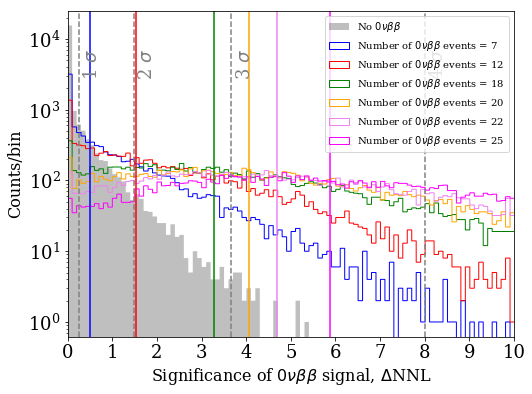

In [18]:
from scipy.stats import chi2
import scipy.stats as st



hist = {}
medians = {}
for Livetime in Livetimes:
    fig = plt.figure(figsize=(8,6))
    
    label = [x[len('DiscoveryPotential_bb0n_'):x.find('ct_')] for x in list(DeltaNLL[Livetime].keys())][1:] # get number of counts from tag name
    FoundNull = np.char.find(list(DeltaNLL[Livetime].keys()), '_0ct_')
    NullIndex = np.where(FoundNull > 0)[0][0]
    NullSet = list(DeltaNLL[Livetime].keys())[NullIndex]
    
    hist[NullSet] = plt.hist(np.abs(DeltaNLL[Livetime][NullSet]), 
                                                         bins=np.linspace(0,100,1000), 
                                                         label=r'No $0\nu\beta\beta$', 
                                                         histtype='stepfilled', 
                                                         color='grey', 
                                                         alpha=0.5)

    medians[Livetime] = []
    for ii,key in enumerate(list(DeltaNLL[Livetime].keys())[1:]):
        print(ii,key)
        hist[key] = plt.hist(np.abs(DeltaNLL[Livetime][key]), 
                             bins=np.linspace(0,100,1000), 
                             label=r'Number of $0\nu\beta\beta$ events = %s' % label[ii], 
                             histtype='step', 
                             color=colors[ii])
        plt.axvline(x=np.median(sorted(np.abs(DeltaNLL[Livetime][key]))), ymin=0, ymax=1000, ls='-', color=colors[ii])
        medians[Livetime].append(np.median(sorted(np.abs(DeltaNLL[Livetime][key]))))

    xmax = 10
    plt.xlim(0,xmax)
    plt.xticks(np.arange(0,xmax+0.1,xmax/10.0))
    plt.yscale('log')
    plt.xlabel(r'Significance of $0\nu\beta\beta$ signal, $\Delta$NNL', fontsize=16)
    plt.ylabel('Counts/bin', fontsize=16)
    plt.legend(loc='upper right', fontsize=10)

    for ii,zval in enumerate(zvals):  
        index = int(st.norm.cdf(ii+1)*len(np.abs(DeltaNLL[Livetime][NullSet])))
        xpos = sorted(np.abs(DeltaNLL[Livetime][NullSet]))[index]
        plt.axvline(x=xpos, ymin=0, ymax=1000, ls='--', color='grey')
        plt.text(xpos+0.1, np.max(hist[NullSet][0])*0.3,r'%d $\sigma$' % (ii+1),rotation=90, color='grey')

    # Significance assuming Wilks' theorem for sigma > 3
    # see slide 11 in https://indico.cern.ch/event/162087/contributions/235303/attachments/189340/265790/cowan_cargese_2.pdf
    for sigma in [4]:
        plt.axvline(x=sigma**2/2.0, ymin=0, ymax=1000, ls='--', color='grey')
        plt.text(sigma**2/2.0+0.1, np.max(hist[NullSet][0])*0.3,r'%d $\sigma$' % (sigma),rotation=90, color='grey')


    plt.savefig('null_hypothesis_%dyrs.pdf' % Livetime, bbox_inches='tight')

In [19]:
import scipy.stats as st

sigma = {}
Cut = {}
XInterp = {}
Interpolation = {}

for Livetime in Livetimes:
    label = [x[len('DiscoveryPotential_bb0n_'):x.find('ct_')] for x in list(DeltaNLL[Livetime].keys())][1:] # get number of counts from tag name
    FoundNull = np.char.find(list(DeltaNLL[Livetime].keys()), '_0ct_')
    NullIndex = np.where(FoundNull > 0)[0][0]
    NullSet = list(DeltaNLL[Livetime].keys())[NullIndex]
    
    sorted_nll = sorted(np.abs(DeltaNLL[Livetime][NullSet]))
    sigma[Livetime] = []
    for ii,key in enumerate(list(DeltaNLL[Livetime].keys())[1:]):
        diff_abs = np.abs(sorted_nll - medians[Livetime][ii])
        nll_val = np.min(diff_abs)
        cut = np.where(diff_abs == nll_val)[0][0]
        print(key, nll_val, cut, cut/len(sorted_nll), st.norm.ppf(cut/len(sorted_nll)), np.sqrt(2*medians[Livetime][ii]))

        sigma[Livetime].append(st.norm.ppf(cut/len(sorted_nll)))
    
    
    XInterp[Livetime] = np.linspace(int(label[0]),int(label[-1]),1000)
    Interpolation[Livetime] = np.interp(XInterp[Livetime], np.array(label).astype(int), sigma[Livetime])
    Diff = np.abs(Interpolation[Livetime] - 3.0)
    Cut[Livetime] = np.where(Diff == np.min(Diff))[0][0]
    print(XInterp[Livetime][Cut[Livetime]])
    print(GetLivetime(XInterp[Livetime][Cut[Livetime]], Livetime))

DiscoveryPotential_bb0n_7ct_10.0yrs 5.970045424863457e-05 17976 0.9005109708446047 1.2844685575996437 0.9975533680188174
DiscoveryPotential_bb0n_12ct_10.0yrs 8.316303022626315e-05 19551 0.9794108806732792 2.0417308318337835 1.7501326480445585
DiscoveryPotential_bb0n_18ct_10.0yrs 0.012810877251566488 19919 0.9978459072237251 2.8546678794730127 2.5596526673436766
DiscoveryPotential_bb0n_20ct_10.0yrs 0.0016163690636918915 19950 0.9993988578298768 3.238337632390029 2.8518908383919723
DiscoveryPotential_bb0n_22ct_10.0yrs 0.047378751459390855 19958 0.9997996192766256 3.5395818673143498 3.062334566458394
DiscoveryPotential_bb0n_25ct_10.0yrs 0.514031524277331 19961 0.9999499048191564 3.8901304165394506 3.425126359292005
18.765765765765764
18.765765765765764 10.0
5.178913927688243e+27


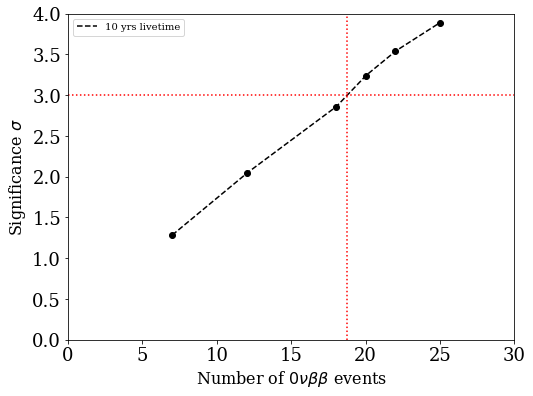

In [20]:
for Livetime in Livetimes:
    label = [x[len('DiscoveryPotential_bb0n_'):x.find('ct_')] for x in list(DeltaNLL[Livetime].keys())][1:] # get number of counts from tag name
    
#     print(XInterp[Livetime])
    fig = plt.figure(figsize=(8,6))
    plt.plot(XInterp[Livetime], Interpolation[Livetime], label='%d yrs livetime' % Livetime, ls='--', color='k')
    plt.scatter(np.array(label).astype(int), sigma[Livetime], color='k')
    plt.axhline(3, color='r', ls=':')
    plt.axvline(XInterp[Livetime][Cut[Livetime]], color='r', ls=':')

    plt.xlim(0,30)
    plt.ylim(0,4)
    plt.xlabel(r'Number of $0\nu\beta\beta$ events', fontsize=16)
    plt.ylabel(r'Significance $\sigma$ ', fontsize=16)
    plt.legend(loc='upper left', fontsize=10)
    plt.savefig('sigma_vs_bb0n_%dyrs.pdf' % Livetime, bbox_inches='tight')